<h1 style="color:rgb(0,120,170)">Neural Networks and Deep Learning</h1>
<h2 style="color:rgb(0,120,170)">Logistic Regression</h2>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torchvision import datasets, transforms
from types import SimpleNamespace
import matplotlib.pyplot as plt
import os

The batch size is a hyperparameter of gradient descent that controls the number of training samples to work through before the model’s internal parameters are updated. The number of epochs is a hyperparameter that defines the number times that the learning algorithm will work through the entire training dataset.

In [2]:
# Hyperparameters
args = SimpleNamespace(batch_size=64, test_batch_size=1000, epochs=1,
                       lr=0.01, momentum=0.5, seed=1, log_interval=100)
torch.manual_seed(args.seed)
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In [3]:
# Data loader (downloads data automatically the first time)
# 0.1307 and 0.3081 are the mean and the std computed on the training set
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(os.path.join('.','..','data'), train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(os.path.join('.','..','data'), train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)

Extracting .\..\data\MNIST\raw\train-images-idx3-ubyte.gz to .\..\data\MNIST\raw


Extracting .\..\data\MNIST\raw\train-labels-idx1-ubyte.gz to .\..\data\MNIST\raw


Extracting .\..\data\MNIST\raw\t10k-images-idx3-ubyte.gz to .\..\data\MNIST\raw


Extracting .\..\data\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\..\data\MNIST\raw
Processing...
Done!


C:\ProgramData\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


If you load the training dataset, each data point will represent a tuple containing an image matrix and label. So let’s take an example if the second number is 5 then 28 x 28 matrix of numbers representing a digit 5. Let’s visualize this pythonically.

torch.Size([60000])
torch.Size([60000, 28, 28])
Input dimension is 784.






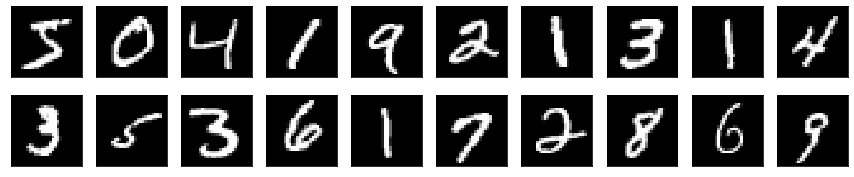

In [4]:
print(train_loader.dataset.targets.shape)
print(train_loader.dataset.data.shape)
input_dim = train_loader.dataset.data.shape[1]*train_loader.dataset.data.shape[2]
print("Input dimension is {}.".format(input_dim))
output_dim = 10

# Plot example images
fig=plt.figure(figsize=(15,3))
for image in range(20):
    show_img = train_loader.dataset.data[image].numpy().reshape(28, 28)
    fig.add_subplot(2,10,image+1)
    plt.xticks([]),plt.yticks([])
    plt.imshow(show_img, cmap='gray')
plt.show()

This is how models are written in pytorch. The key component is the forward pass where all the defined functions are put together and where automatic differentiation is executed in reverse order:

In [5]:
# Model
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        out = self.linear(x)
        return F.log_softmax(out, dim=1)
        #return out

In [6]:
# This function trains the model for one epoch
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = Variable(data.view(-1, input_dim))
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [7]:
# This function evaluates the model on the test data
def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = Variable(data.view(-1, input_dim))
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

This is how models are called in pytorch. SGD is used as optimizer:

In [8]:
# Main
model = LogisticRegression(input_dim, output_dim).to(device)
optimizer = optim.SGD(model.parameters(), lr=args.lr, 
                      momentum=args.momentum)

for epoch in range(1, args.epochs + 1):
    train(args, model, device, train_loader, optimizer, epoch)
    test(args, model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.194524
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.450763
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.595396
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.355295
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.372000
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.248890
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.334487
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.373393
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.372804
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.219569

Test set: Average loss: 0.3131, Accuracy: 9094/10000 (90.94%)

